In [1]:
!pip install torchmetrics, albumentations

# Libraries

In [4]:
import os
import torch
import torchvision
import torchmetrics
import cv2
from torchmetrics.functional import char_error_rate
from sklearn import metrics
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
torch.random.manual_seed(777)
torch.cuda.random.manual_seed_all(777)
torch.cuda.random.manual_seed(777)

# Loading Data and Preprocessing

In [71]:
!unzip -qq 'CCPD2019-dl1.zip'

replace CCPD2019-dl1/test/0287-皖AYX440.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [6]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽",
             "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁",
             "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵",
             "云", "藏", "陕", "甘", "青", "宁", "新", "警",
             "学"]

ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
       'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
       'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', 'O']

alphabet = provinces + ads 

In [7]:
CTC_BLANK = '<CTC>'

class Tokenizer:
    
    def __init__(self, alphabet):
        self.char_dict = {val: i + 1 for (i, val) in enumerate(alphabet)}
        self.char_dict[CTC_BLANK] = 0
        self.rev_char_dict = self.reverse_dict(self.char_dict)

    def tokenize(self, word_list):
        tokens = [self.char_dict[char] if char in self.char_dict
             else self.char_dict[OOV_TOKEN]
             for char in word_list]
        return tokens
    
    def untokenize(self, tokenized_words):
        untokens = ''
        for idx, token in enumerate(tokenized_words):
            if not (idx > 0 and token == tokenized_words[idx - 1]) and token != self.char_dict[CTC_BLANK]:
                untokens += self.rev_char_dict[token]
        return untokens

    def get_num_chars(self):
        return len(self.char_dict)
    
    @staticmethod
    def reverse_dict(d):
        return {v: k for k, v in d.items()}

In [8]:
SIZE = 224
transforms = A.Compose([
    A.Resize(32, SIZE),
    A.Normalize(),
    ToTensorV2()
])

In [155]:
class OCRDataSet(torch.utils.data.Dataset):
    def __init__(self, img_folder, tokenizer, transforms):
        super().__init__()
        self.img_folder = img_folder
        self.tokenizer = tokenizer
        self.dataset = []
        self.labels = []
        self.tokenized_labels = []
        self.img_name = []
        self.transforms = transforms
        self._get_data_from_folder()
        
    def _get_data_from_folder(self):
             for img_name in tqdm(os.listdir(self.img_folder)):
                img = cv2.imread(os.path.join(self.img_folder, img_name))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                transformed = self.transforms(image=img)
                img_tensor = transformed['image']
                self.dataset.append(img_tensor)
                self.labels.append(img_name[-11:-4])
                self.img_name.append(img_name)
                self.tokenized_labels.append(torch.LongTensor(self.tokenizer.tokenize(img_name[-11:-4])))

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.dataset[idx], self.labels[idx], self.tokenized_labels[idx]
    
    def get_img_name(self, idx):
        return self.img_name[idx]

In [156]:
train_folder = 'CCPD2019-dl1/train/'
test_folder = 'CCPD2019-dl1/test/'

In [157]:
tokenizer = Tokenizer(alphabet)
train_dataset = OCRDataSet(train_folder, tokenizer, transforms)
test_dataset = OCRDataSet(test_folder, tokenizer, transforms)

100%|██████████| 9999/9999 [00:05<00:00, 1987.42it/s]


In [101]:
def collate(batch):
    imgs, labels, tok_labels = zip(*batch)
    imgs = torch.stack(imgs, 0)
    tok_pad_labels = torch.nn.utils.rnn.pad_sequence(tok_labels, batch_first=True, padding_value=0)
    return imgs, labels, tok_pad_labels

In [102]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=128, 
                                          shuffle=True,
                                          collate_fn=collate)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=128, 
                                          shuffle=False,
                                          collate_fn=collate)

# MODEL

In [103]:
class CNN_encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(1,2), stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.batchnorm = nn.BatchNorm2d(256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(1,2), stride=2)
        
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=1, padding=0)

    def forward(self, x):
        
        x = self.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.relu((self.conv2(x)))
        x = self.maxpool2(x)
        x = self.batchnorm(self.relu(self.conv3(x)))
        x = self.maxpool3(x)
        x = self.relu(self.conv4(x))
        
        return x
    
    
class BiLSTM_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        res, _ = self.lstm(x)
        return res


class CRNN(nn.Module):
    def __init__(
        self, number_class_symbols, time_feature_count=16, lstm_hidden=128,
        lstm_len=2,
    ):
        super().__init__()
        self.encoder = CNN_encoder() 
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (time_feature_count, time_feature_count))
        self.decoder = BiLSTM_decoder(time_feature_count, lstm_hidden, lstm_len)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(time_feature_count, number_class_symbols)
        )

    def forward(self, x):
        x = self.encoder(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.decoder(x)
        x = self.classifier(x)
        x = x.permute(1, 0, 2)
        x = nn.functional.log_softmax(x, dim=2)
        return x

# Training

In [135]:
import math
import torch
import torch.optim

from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(torch.optim.Optimizer):
    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, 
        weight_decay: float = 0, eps: float = 1e-6, decouple_decay=False,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1)")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, 
                        weight_decay=weight_decay, decouple_decay=decouple_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        # step counter must be stored in state to ensure correct behavior under
        # optimizer sharding
        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]
            decouple_decay = group["decouple_decay"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0 and not decouple_decay:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    if eps == 0:
                        rms_masked_vals[rms_masked_vals == 0] = float('inf')

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    if eps == 0:
                        rms[rms == 0] = float('inf')

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    if decay != 0 and decouple_decay:
                        p_old = p.data.clone()

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)
                    
                    if decay != 0 and decouple_decay:
                        p.data.add_(p_old, alpha=-lr*decay)


        self.state['k'] += 1
        return loss

In [140]:
model = CRNN(tokenizer.get_num_chars())
criterion = torch.nn.CTCLoss(blank=0, reduction='sum', zero_infinity=True)
optimizer = MADGRAD(model.parameters(), lr=4e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=2, verbose=True
)

In [141]:
def train_epoch(model, train_dataloader, optimizer, criterion):
    epoch_loss = 0
    model.train()
    model.to(device)
    for (imgs, labels, tokenized_labels) in train_dataloader:

        b_size = imgs.shape[0]
        imgs = imgs.to(device)
        labels = labels
        tokenized_labels = tokenized_labels.to(device)
        outputs = model(imgs)

        input_lengths = torch.full(
                size=(b_size,), fill_value=outputs.size(0), dtype=torch.long
        )
        target_lengths = torch.full(
            size=(b_size,), fill_value=tokenized_labels.size(1), dtype=torch.long
        )

        loss = criterion(
            outputs, tokenized_labels, input_lengths, target_lengths
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(train_dataloader)


def val_epoch(model, test_dataloader):
    epoch_loss = 0
    preds = []
    total_step = len(test_dataloader)
    model.eval()
    model.to(device)
    for i, (imgs, labels, tokenized_labels) in enumerate(test_dataloader):
        with torch.no_grad():
            b_size = imgs.shape[0]
            imgs = imgs.to(device)
            tokenized_labels = tokenized_labels.to(device)
            outputs = model(imgs)

            input_lengths = torch.full(
                    size=(b_size,), fill_value=outputs.size(0), dtype=torch.long
            )
            target_lengths = torch.full(
                size=(b_size,), fill_value=tokenized_labels.size(1), dtype=torch.long
            )

            loss = nn.CTCLoss(blank=0)(
                outputs, tokenized_labels, input_lengths, target_lengths
            )
            epoch_loss += loss.item()
            preds.extend(outputs.argmax(2).T)
            
    return epoch_loss / total_step, preds

In [142]:
def output_untokenizer(output):
    output = output.tolist()
    output = tokenizer.untokenize(output)
    return output

In [143]:
from sklearn.metrics import accuracy_score

n_epoch = 8
y_test = np.array(test_dataset.labels)
y_train = np.array(train_dataset.labels)
for i in tqdm(range(n_epoch)):
    decoded = []
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion)
    test_loss, test_preds = val_epoch(model, test_dataloader)
    _, train_preds = val_epoch(model, train_dataloader)
    test_preds = np.array(list(map(output_untokenizer, test_preds)))
    train_preds = np.array(list(map(output_untokenizer, train_preds)))
    print(f'Epoch: {i + 1}; Test_loss: {test_loss}')
    print(f'Test_accuracy: {accuracy_score(y_test, test_preds)}, Test_CER: {char_error_rate(y_test, test_preds)} ')
    scheduler.step(test_loss)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1; Test_loss: 0.17336191133230547


 12%|█▎        | 1/8 [00:57<06:41, 57.35s/it]

Test_accuracy: 0.8038803880388039, Test_CER: 0.038601361215114594 
Epoch: 2; Test_loss: 0.07018297578243515


 25%|██▌       | 2/8 [01:56<05:49, 58.21s/it]

Test_accuracy: 0.9266926692669267, Test_CER: 0.01418916042894125 
Epoch: 3; Test_loss: 0.059420637014215884


 38%|███▊      | 3/8 [02:52<04:47, 57.42s/it]

Test_accuracy: 0.9438943894389439, Test_CER: 0.010730717331171036 
Epoch: 4; Test_loss: 0.07773811828722305


 50%|█████     | 4/8 [03:48<03:47, 56.78s/it]

Test_accuracy: 0.9283928392839284, Test_CER: 0.014091351069509983 
Epoch: 5; Test_loss: 0.058232629926627665


 62%|██████▎   | 5/8 [04:45<02:50, 56.91s/it]

Test_accuracy: 0.9481948194819482, Test_CER: 0.009708737954497337 
Epoch: 6; Test_loss: 0.05124230934690118


 75%|███████▌  | 6/8 [05:43<01:54, 57.10s/it]

Test_accuracy: 0.9521952195219522, Test_CER: 0.009102600626647472 
Epoch: 7; Test_loss: 0.039478539975501506


 88%|████████▊ | 7/8 [06:40<00:57, 57.37s/it]

Test_accuracy: 0.9617961796179618, Test_CER: 0.007258698344230652 
Epoch: 8; Test_loss: 0.04685749313307785


100%|██████████| 8/8 [07:37<00:00, 57.20s/it]

Test_accuracy: 0.9553955395539554, Test_CER: 0.008060482330620289 


# Calculate metrics on Test Dataset

### Accuracy ont Test

In [144]:
accuracy_score(y_test, test_preds)

0.9553955395539554

### CER

In [145]:
char_error_rate(y_test, test_preds).item()

0.008060482330620289

# Check on bad samples

In [158]:
cers = []
for i in range(len(y_test)):
    cer = char_error_rate(y_test[i], test_preds[i]).item()
    cers.append((i, cer))
cers = sorted(cers, key=lambda x: x[1], reverse=True)

In [159]:
cers[0][0]

1684

In [162]:
bad_imgs = []
for i in range(10):
    img_name = test_dataset.get_img_name(cers[i][0])
    img = cv2.imread(os.path.join(test_folder, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bad_imgs.append(img)

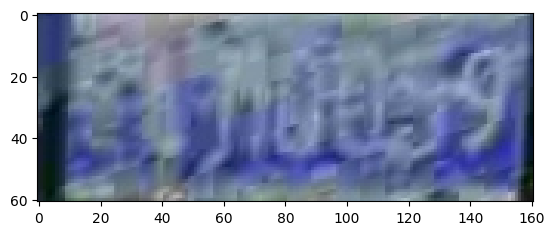

In [163]:
plt.imshow(bad_imgs[0])

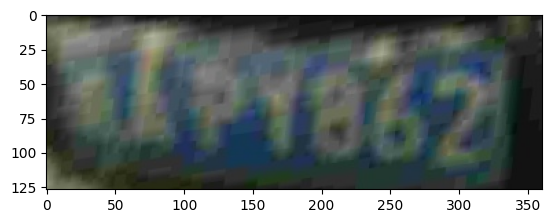

In [164]:
plt.imshow(bad_imgs[1])

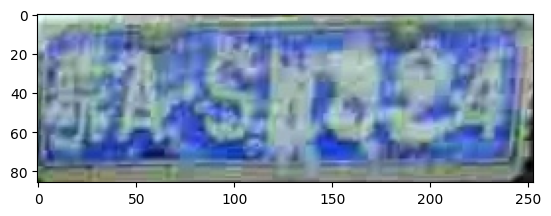

In [165]:
plt.imshow(bad_imgs[2])

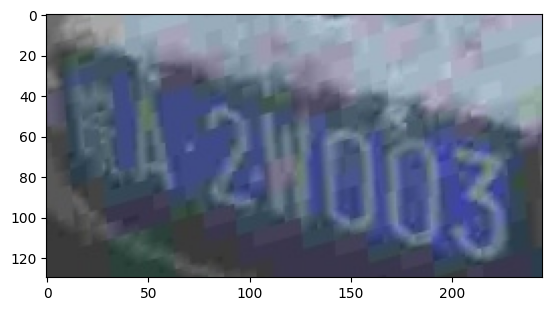

In [166]:
plt.imshow(bad_imgs[3])

# Results and Summary

1. Общие наблюдения и результаты:
   Данный способ решения хорошо справляется с задачей OCR, модель себя показала плохо на семплах, которые имеют плохое качество изображения, имеют блюр, засвечивания
2. Недостатки решения
    Тут стоит отметить, что модель может ошибаться на семплах, где все не так плохо с качеством, но текст находится под углом и мы это не учитываем
3. Способы улучшения
    1) Аугментации, с небольшим поворотом текста, тк модель может ошибаться на семплах, где текст под углом. Аугментации с блюром, контрастностью
    2) Тюнинг параметров модели
    3) Попробовать другие Encoder модели, взять свертку глубже или же попробовать Visual Tranformer
    4) Попробовать другие Decoder модели
    5) Возможно стоит попробовать попытасться улучшить качество исходных изображений с помощью предобученного Super Resolution GAN'а и уже на них тренировать нашу модель